In [1]:
%%markdown
Importes Iniciales



Importes Iniciales




In [2]:
import folium
import urllib3
from ucimlrepo import fetch_ucirepo
import random
import base64
import pandas as pd
import numpy as np
import math
from folium.features import DivIcon
from ucimlrepo import fetch_ucirepo, list_available_datasets, dotdict, fetch
from datetime import datetime
import math
import calendar
import matplotlib.pyplot as plt
import geodatasets
import geopandas
# check which datasets can be imported
# list_available_datasets()



# import dataset
real_state_valuation = fetch_ucirepo(id=477)
# print(real_state_valuation.metadata.additional_info.summary)
# print('\n')
# print(real_state_valuation.metadata.additional_info.variable_info)
# print('\n')
# print(real_state_valuation.variables.description.to_string())
# print('\n')
# print(real_state_valuation.data.original.to_string())
# print('\n')
# print(real_state_valuation.data.headers)
# print('\n') R

df = real_state_valuation.data.original.copy()


def date_transformation(date):
    year = int(date.split('.')[0])
    month = int(date.split('.')[1])
    day = month
    proportion = 12 / 1000
    converted_month = math.floor(proportion * month)
    if converted_month == 0:
        converted_month = 1
    # name = calendar.month_name[converted_month]
    # calendario = calendar.month(year, converted_month)
    # days_of_the_month = [number for number in calendario if int(number) ]
    # print(days_of_the_month)
    date = datetime(year=year, month=converted_month, day=1)
    return date


df['X1 transaction date'] = df['X1 transaction date'].apply(lambda date: date_transformation(str(date)))
df.drop(columns=['No'], inplace=True)
df['X1 transaction date'] = pd.to_datetime(df['X1 transaction date'])
df.sort_values(by='X1 transaction date', axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
prices = df['Y house price of unit area'].to_list()
color_options = {
        "red",
        "darkred",
        "lightred",
        "orange",
        "beige",
        "green",
        "darkgreen",
        "lightgreen",
        "blue",
        "darkblue",
        "cadetblue",
        "lightblue",
        "purple",
        "darkpurple",
        "pink",
        "white",
        "gray",
        "lightgray",
        "black",
    }

min_price = min(prices)
max_price = max(prices)
intermediate_price= np.median(prices)
num_categorias = 5
# Categorizar los números en intervalos aproximadamente iguales
intervalos = [min_price,intermediate_price, max_price,np.inf]

etiquetas = ['Super Barata','Barata', 'Media','Cara', 'Super Cara']
colores = ['lightgreen', 'green','darkgreen','red', 'darkred']

# categorias = pd.cut(prices, bins=intervalos, labels=etiquetas)
df = df.assign(categorias=pd.qcut(df['Y house price of unit area'], q=num_categorias, labels=etiquetas))
df = df.assign(colores_zone=pd.qcut(df['Y house price of unit area'], q=num_categorias, labels=colores))
df.sort_values(by='Y house price of unit area', ascending=True, inplace=True)


lat = df['X5 latitude'].to_list()
lon = df['X6 longitude'].to_list()

max_lat = max(lat) + 0.007
min_lat = min(lat) - 0.007
max_lon = max(lon) + 0.007
min_lon = min(lon) - 0.007

m = folium.Map(location=[24.96515, 121.53737], zoom_start=13,
               control_scale=True,
               scrollWheelZoom=False, )


    
for i in df.index:

    latitud = df.loc[df.index == i]['X5 latitude'].to_list()[0]
    longitud = df.loc[df.index == i]['X6 longitude'].to_list()[0]
    price = df.loc[df.index == i]['Y house price of unit area'].to_list()[0]
    age = df.loc[df.index == i]['X2 house age'].to_list()[0]
    colores = df.loc[df.index == i]['colores_zone'].to_list()[0]
    icon_color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])] 
    iconos = folium.Icon(
        color=colores, prefix='fa', icon='fa-house' ,
                         # icon_color=icon_color
)

    marker = folium.Marker(
        location=[latitud, longitud],
        # coordinates for the marker (Earth Lab at CU Boulder)
        popup=f'House price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared) - {price} pings',
        # pop-up label for the marker
        # icon=number_DivIcon(col_hex[num], num),
        icon=iconos,
        tooltip=f'Antiquity: {age} years')
    marker.add_to(m)

        
ls = folium.PolyLine(
    locations=[[max_lat, max_lon],
               [max_lat, min_lon],
               [min_lat, min_lon],
               [min_lat, max_lon],
               [max_lat, max_lon]], color="purple"
)
ls.add_child(folium.Popup("outline Popup on Polyline"))
ls.add_to(m)

# class MapWrapper:
#     def __init__(self, m):
#         self.html = m.get_root().render()
#     
#     def add_html(self, html_string):
#         self.html += html_string
# 
#     def _repr_html_(self):
#         # Copied from folium.element.Figure
#         html = "data:text/html;charset=utf-8;base64," + base64.b64encode(self.html.encode('utf8')).decode('utf8')
#         iframe = (
#         '<div style="width:100%;">'
#         '<div style="position:relative;width:100%;height:0;padding-bottom:60%;">'
#         '<iframe src="{html}" style="position:absolute;width:100%;height:100%;left:0;top:0;'
#         'border:none !important;" '
#         'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
#         '</iframe>'
#         '</div></div>').format
#         return iframe(html=html)
# mapper = MapWrapper(m)
# mapper.add_html(('<style>.leaflet-popup-content{color:#440154 !important}'
#                  '.leaflet-control{color:#440154}</style>'))
# 


In [3]:
m

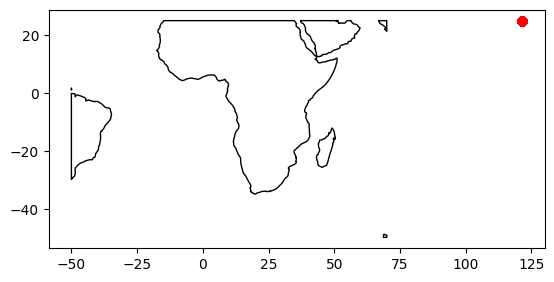

In [4]:
from geodatasets import get_path
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['X6 longitude'], df['X5 latitude']), crs="EPSG:4326")
world = geopandas.read_file(get_path("naturalearth.land"))
70
# We restrict to South America.
ax = world.clip([-50, -55, 70, 25]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

In [5]:
!jupyter nbconvert --to html real_state.ipynb
    

[NbConvertApp] Converting notebook real_state.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: 'execution_count' is a required property

Failed validating 'required' in code_cell:

On instance['cells'][1]:
{'cell_type': 'code',
 'id': '60831451450d355f',
 'metadata': {'collapsed': False},
 'outputs': ['...0 outputs...'],
 'source': 'import folium\n'
           'import urllib3\n'
           'from ucimlrepo import fetch_ucirepo...'}
[NbConvertApp] ERROR | Notebook is invalid after preprocessor <nbconvert.preprocessors.tagremove.TagRemovePreprocessor object at 0x107b3a330>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/Library/Frameworks/Python